# Simulation

Wind speed -> Power -> H2

In [1]:
import torch
import numpy as np
import pandas as pd
from REStats.utils import load_SCADA, filter_outliers, downsample, standardize
from REStats.models import backtest, power_curve
from REStats.models.turbulence_intensity import persistence_turbulence_intensity
from REStats.models.wind_dir import persistence_wind_dir
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from REStats.plots import save_figs
import seaborn as sns
from electrolyzer import run_electrolyzer

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt_18 = load_SCADA(2018)
wt_19 = load_SCADA(2019)

## Train + Generate Forecast

In [5]:
fcast_train = wt_19[(wt_19.index >= "2019-02-01") & (wt_19.index < "2019-03-01")].copy()
test = wt_19[(wt_19.index >= "2019-03-01") & (wt_19.index < "2019-04-01")].copy()
test = downsample(test)

In [6]:
forecasts_full, (fcast_rmse, fcast_mae) = backtest(downsample(fcast_train), test)

fcast_rmse, fcast_mae

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:28, 52.81it/s, step size=8.12e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:26, 57.53it/s, step size=7.75e-01, acc. prob=0


Forecast RMSE: 1.1149765094738722
Forecast MAE: 0.8302879076642369


(1.1149765094738722, 0.8302879076642369)

## Train + Predict Power Curve

In [7]:
pc_train_raw = pd.concat([wt_18, fcast_train])
cut_in = 2.0
cut_out = 18.0
pc_filtered = filter_outliers(pc_train_raw)
pc_train = downsample(pc_filtered)
pc_train = pc_train[(pc_train.wind_speed >= cut_in) & (pc_train.wind_speed < cut_out)]

pc_train.tail()

,wind_speed,wind_dir,power,turbulence_intensity
Date,,,,
2019-02-28 19:00:00,4.730932,286.072572,221.701962,0.035886
2019-02-28 20:00:00,5.325628,300.330975,313.219354,0.030987
2019-02-28 21:00:00,4.284668,308.103162,171.316518,0.037701
2019-02-28 22:00:00,2.904026,316.986263,36.895107,0.060341
2019-02-28 23:00:00,3.489935,316.893271,71.923876,0.042589


### Wind only

In [8]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(pc_train.wind_speed.to_numpy()[:, None])

pc_train, _ = train_test_split(pc_train, stratify=bins, train_size=800, random_state=1)

In [9]:
train_std = standardize(pc_train)

X_train = torch.tensor(train_std.wind_speed)
y_train = torch.tensor(train_std.power)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.769   lengthscale: [[0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.732   lengthscale: [[0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.693   lengthscale: [[0.7979174852371216]]   noise: 0.598
Iter 4/100 - Loss: 0.655   lengthscale: [[0.8535422086715698]]   noise: 0.554
Iter 5/100 - Loss: 0.615   lengthscale: [[0.9110930562019348]]   noise: 0.513
Iter 6/100 - Loss: 0.576   lengthscale: [[0.9703762531280518]]   noise: 0.474
Iter 7/100 - Loss: 0.535   lengthscale: [[1.0311700105667114]]   noise: 0.437
Iter 8/100 - Loss: 0.494   lengthscale: [[1.0932085514068604]]   noise: 0.403
Iter 9/100 - Loss: 0.453   lengthscale: [[1.1561676263809204]]   noise: 0.370
Iter 10/100 - Loss: 0.411   lengthscale: [[1.219658613204956]]   noise: 0.340
Iter 11/100 - Loss: 0.368   lengthscale: [[1.283230185508728]]   noise: 0.312
Iter 12/100 - Loss: 0.325   lengthscale: [[1.3463709354400635]]   noise: 0.286
Iter 13/100 - Loss: 0.282   lengthscale: [[1.4085071086883545]]

In [10]:
test_sort = test.sort_values("wind_speed")
test_sort_std = standardize(test_sort, ref_df=pc_train)
X_test_torch = torch.tensor(test_sort_std.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

In [11]:
test_pred_tf = test_pred.mean.numpy() * pc_train.power.std() + pc_train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse} kW")

Test RMSE: 81.63548640845919 kW


In [12]:
fcast = forecasts_full["mean"]
fcast_std = (fcast - pc_train.wind_speed.mean())/pc_train.wind_speed.std()
fcast_torch = torch.tensor(fcast_std)

test_pred = power_curve.predict(model, likelihood, fcast_torch)

test_pred_tf = test_pred.mean.numpy() * pc_train.power.std() + pc_train.power.mean()

# filter out values outside operating range
pred_filtered = np.zeros(len(test_pred_tf))

for i, pred in enumerate(fcast):
    if (pred < cut_in) or (pred >= cut_out):
        pred_filtered[i] = 0.0
    else:
        pred_filtered[i] = test_pred_tf[i]


test_rmse = mean_squared_error(pred_filtered, test[1:].power, squared=False)
test_mae = mean_absolute_error(pred_filtered, test[1:].power)
print(f"Test RMSE: {test_rmse} kW")
print(f"Test MAE: {test_mae} kW")

Test RMSE: 252.55321087240833 kW
Test MAE: 164.00674178229383 kW


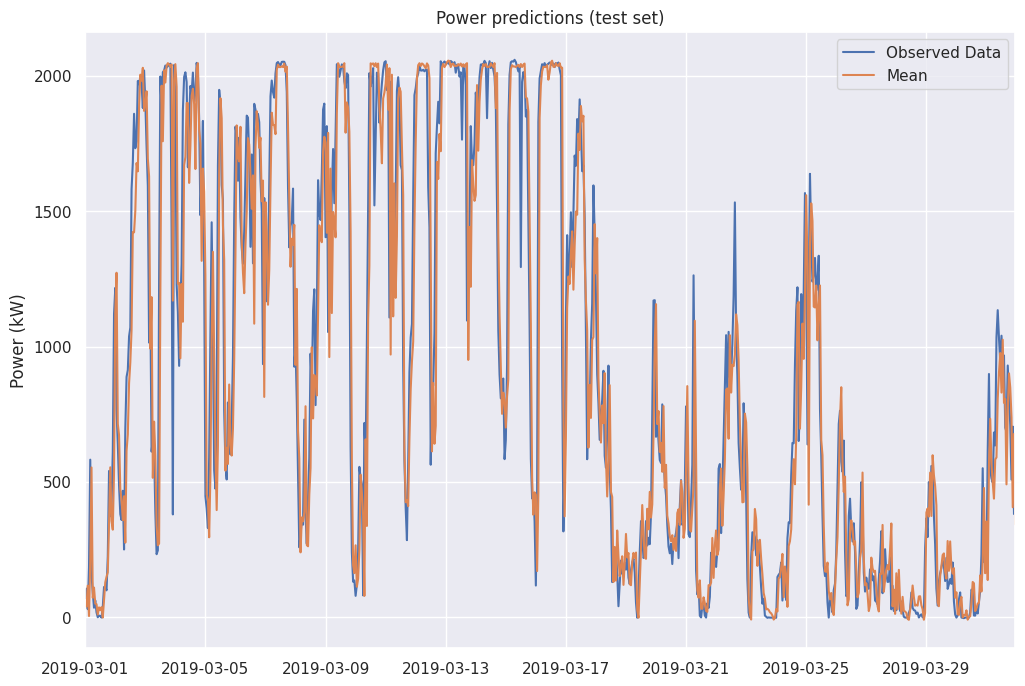

In [13]:
with torch.no_grad():
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xmargin(0)
    ax.set_title("Power predictions (test set)")
    ax.set_ylabel("Power (kW)")
    
    # Plot test data
    ax.plot(test.index, test.power)
    # Plot predictive means
    ax.plot(test.index[1:], test_pred_tf)

    ax.legend(['Observed Data', 'Mean'])
    
figs["power_fcast"] = f

In [14]:
test.sort_values("wind_speed")

,wind_speed,wind_dir,power,turbulence_intensity
Date,,,,
2019-03-28 08:00:00,1.586547,254.950152,-0.836973,0.178890
2019-03-23 18:00:00,1.634989,79.512201,-0.368724,0.137904
2019-03-28 09:00:00,1.779671,246.032133,-0.978143,0.213017
2019-03-01 13:00:00,1.817944,218.029570,-0.847465,0.233115
2019-03-30 08:00:00,1.866275,249.357490,-1.108614,0.226324
...,...,...,...,...
2019-03-16 11:00:00,17.571387,231.217524,2049.234747,0.064208
2019-03-16 10:00:00,18.159967,231.087645,2044.839231,0.028054
2019-03-16 09:00:00,18.187620,235.318158,2041.134007,0.046384


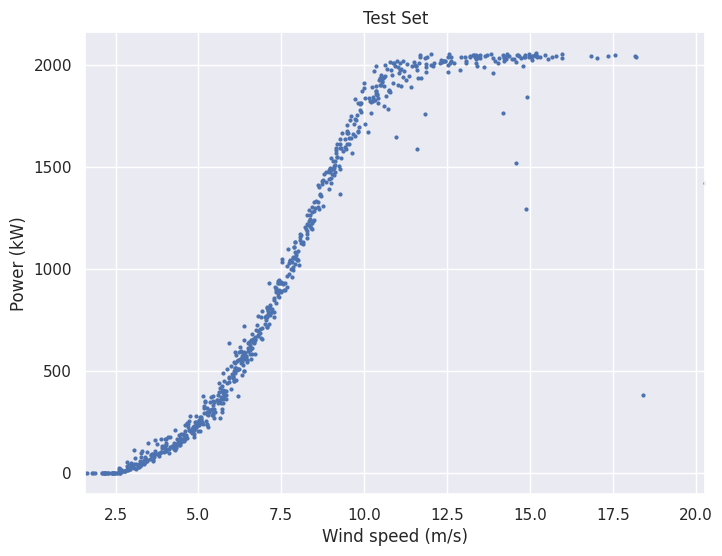

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xmargin(0)
ax.set_title("Test Set")
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.scatter(test.wind_speed, test.power, s=4)

figs["sim_test_set"] = fig

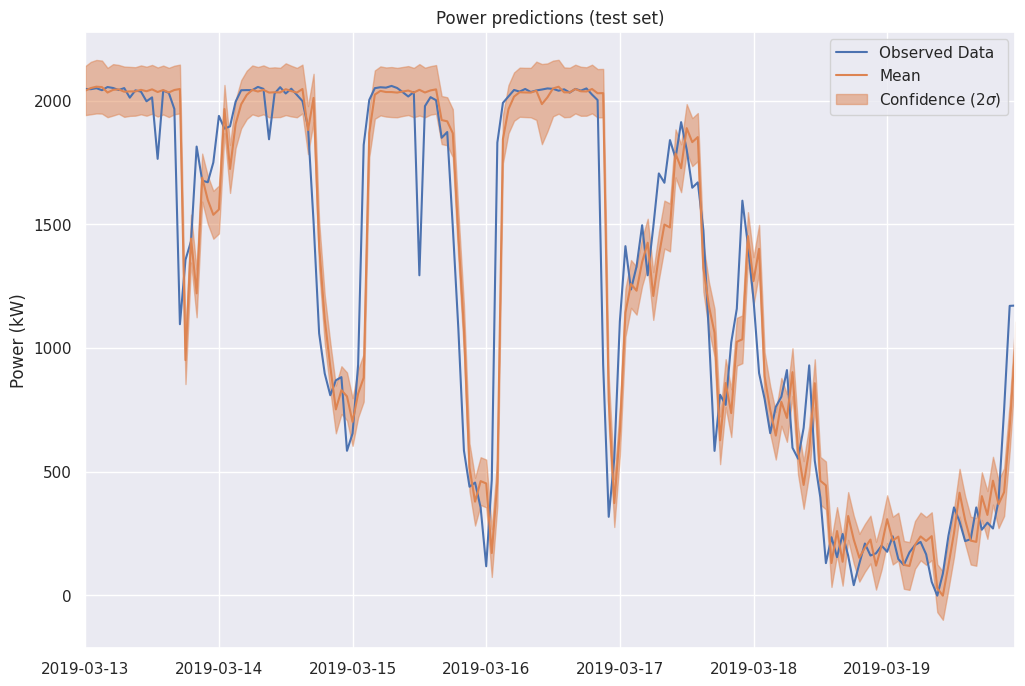

In [16]:
with torch.no_grad():    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xmargin(0)
    ax.set_title("Power predictions (test set)")
    ax.set_ylabel("Power (kW)")
    
    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    
    res_df = test[1:].copy()
    res_df["lower"] = lower.numpy() * pc_train.power.std() + pc_train.power.mean()
    res_df["upper"] = upper.numpy() * pc_train.power.std() + pc_train.power.mean()
    res_df["pred"] = test_pred_tf
    
    t = res_df[(res_df.index >= "2019-03-13") & (res_df.index < "2019-03-20")]
    
    # Plot test data
    ax.plot(t.index, t.power)
    # Plot predictive means
    ax.plot(t.index, t.pred)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(t.index, t.lower, t.upper, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["sim_power_fcast"] = f

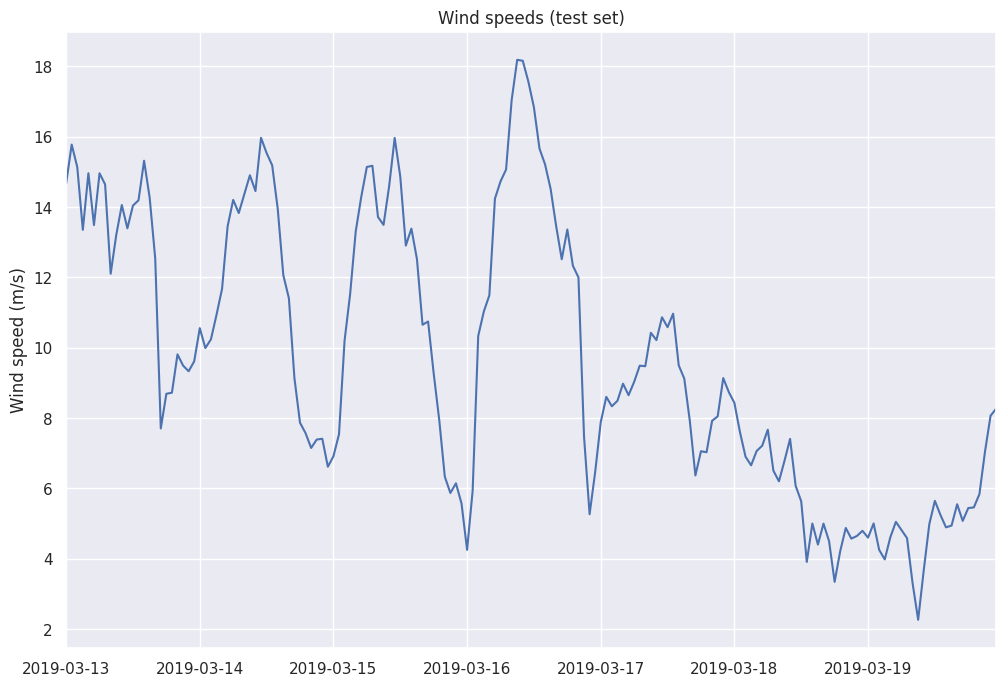

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_title("Wind speeds (test set)")
ax.set_ylabel("Wind speed (m/s)")

ax.plot(t.index, t.wind_speed)

figs["sim_ws_test_set"] = fig

### Full inputs

In [18]:
ti_fcast = persistence_turbulence_intensity(test)
wd_fcast = persistence_wind_dir(test)
wind_fcast = forecasts_full["mean"]

forecasts = pd.DataFrame({"turbulence_intensity": ti_fcast, "wind_dir": wd_fcast, "wind_speed": wind_fcast}, index=wind_fcast.index)
forecasts

,turbulence_intensity,wind_dir,wind_speed
2019-03-01 01:00:00,0.202915,339.547010,3.153974
2019-03-01 02:00:00,0.156203,340.855991,4.036286
2019-03-01 03:00:00,0.224087,309.899779,2.487269
2019-03-01 04:00:00,0.190343,308.005519,4.726031
2019-03-01 05:00:00,0.208101,301.975517,6.421433
...,...,...,...
2019-03-31 19:00:00,0.082032,45.372467,7.375245
2019-03-31 20:00:00,0.037552,52.399146,7.046009
2019-03-31 21:00:00,0.134402,69.654713,5.828876
2019-03-31 22:00:00,0.165642,77.496178,6.849834


In [19]:
forecasts_std = standardize(forecasts, ref_df=pc_train)

In [20]:
X_test2 = torch.tensor(forecasts_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

X_train2 = torch.tensor(train_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)
y_train2 = torch.tensor(train_std.power, dtype=torch.float32)

model2, likelihood2 = power_curve.fit(X_train2, y_train2, dims=2)
test_pred2 = power_curve.predict(model2, likelihood2, X_test2)

Iter 1/100 - Loss: 0.807   lengthscale: [[0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.766   lengthscale: [[0.7443966269493103, 0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.726   lengthscale: [[0.7978913187980652, 0.797934353351593]]   noise: 0.598
Iter 4/100 - Loss: 0.685   lengthscale: [[0.8534078598022461, 0.8535900115966797]]   noise: 0.554
Iter 5/100 - Loss: 0.645   lengthscale: [[0.910686194896698, 0.9111835360527039]]   noise: 0.513
Iter 6/100 - Loss: 0.603   lengthscale: [[0.9694383144378662, 0.9705319404602051]]   noise: 0.474
Iter 7/100 - Loss: 0.562   lengthscale: [[1.0293570756912231, 1.031449317932129]]   noise: 0.437
Iter 8/100 - Loss: 0.520   lengthscale: [[1.0901215076446533, 1.0937442779541016]]   noise: 0.403
Iter 9/100 - Loss: 0.477   lengthscale: [[1.151397705078125, 1.1572177410125732]]   noise: 0.370
Iter 10/100 - Loss: 0.434   lengthscale: [[1.2128398418426514, 1.2216644287109375]]   noise: 0.340
Iter 11/100 - Loss: 0.3

Iter 85/100 - Loss: -1.106   lengthscale: [[1.395473837852478, 4.826999187469482]]   noise: 0.006
Iter 86/100 - Loss: -1.106   lengthscale: [[1.395571231842041, 4.8627471923828125]]   noise: 0.006
Iter 87/100 - Loss: -1.106   lengthscale: [[1.3958650827407837, 4.898472309112549]]   noise: 0.006
Iter 88/100 - Loss: -1.106   lengthscale: [[1.3963209390640259, 4.934154987335205]]   noise: 0.006
Iter 89/100 - Loss: -1.106   lengthscale: [[1.396882176399231, 4.969773292541504]]   noise: 0.006
Iter 90/100 - Loss: -1.106   lengthscale: [[1.3974748849868774, 5.005307197570801]]   noise: 0.006
Iter 91/100 - Loss: -1.106   lengthscale: [[1.3980319499969482, 5.040737628936768]]   noise: 0.006
Iter 92/100 - Loss: -1.106   lengthscale: [[1.3984768390655518, 5.076047420501709]]   noise: 0.006
Iter 93/100 - Loss: -1.106   lengthscale: [[1.398728847503662, 5.111217021942139]]   noise: 0.006
Iter 94/100 - Loss: -1.106   lengthscale: [[1.398748755455017, 5.146234035491943]]   noise: 0.006
Iter 95/100 - 

In [21]:
forecasts_std

,turbulence_intensity,wind_dir,wind_speed
2019-03-01 01:00:00,0.202915,1.071024,-1.214555
2019-03-01 02:00:00,0.156203,1.084659,-0.872255
2019-03-01 03:00:00,0.224087,0.762202,-1.473209
2019-03-01 04:00:00,0.190343,0.742470,-0.604663
2019-03-01 05:00:00,0.208101,0.679658,0.053082
...,...,...,...
2019-03-31 19:00:00,0.082032,-1.993261,0.423122
2019-03-31 20:00:00,0.037552,-1.920067,0.295392
2019-03-31 21:00:00,0.134402,-1.740323,-0.176805
2019-03-31 22:00:00,0.165642,-1.658642,0.219284


In [22]:
test_pred_tf2 = test_pred2.mean.numpy() * pc_train.power.std() + pc_train.power.mean()

# filter out values outside operating range
pred_filtered2 = np.zeros(len(test_pred_tf2))

for i, pred in enumerate(forecasts.wind_speed):
    if (pred < cut_in) or (pred >= cut_out):
        pred_filtered2[i] = 0.0
    else:
        pred_filtered2[i] = test_pred_tf2[i]


test_rmse2 = mean_squared_error(pred_filtered2, test[1:].power, squared=False)
test_mae2 = mean_absolute_error(pred_filtered2, test[1:].power)
print(f"Test RMSE: {test_rmse2} kW")
print(f"Test MAE: {test_mae2} kW")

Test RMSE: 254.26542010063758 kW
Test MAE: 165.4610757010111 kW


In [23]:
modeling_options = "../sim/modeling_options.yaml"
_, h2_prod = run_electrolyzer(modeling_options, test.power.values * 1e3)

_, h2_prod_fcast = run_electrolyzer(modeling_options, pred_filtered * 1e3)

h2_prod

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/electrolyzer/stack.py:308: RuntimeWarning: invalid value encountered in scalar divide
  voltage_perc = (max(self.voltage_signal) - min(self.voltage_signal)) / max(
/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/electrolyzer/stack.py:308: RuntimeWarning: invalid value encountered in scalar divide
  voltage_perc = (max(self.voltage_signal) - min(self.voltage_signal)) / max(


,power_signal,curtailment,kg_rate,stack_1_deg,stack_1_fatigue,stack_1_cycles,stack_1_uptime,stack_1_kg_rate,stack_1_curr_density,stack_2_deg,...,stack_3_cycles,stack_3_uptime,stack_3_kg_rate,stack_3_curr_density,stack_4_deg,stack_4_fatigue,stack_4_cycles,stack_4_uptime,stack_4_kg_rate,stack_4_curr_density
0,70749.123367,0.000000,1.328482,0.000000e+00,0,0.0,3600.0,0.000369,0.379957,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000
1,105734.909243,0.000000,1.926854,9.310845e-07,0,0.0,7200.0,0.000535,0.550597,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000
2,30116.904720,0.030117,0.000000,9.310845e-07,0,1.0,7200.0,0.000000,0.550597,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000
3,184125.469177,0.000000,3.195573,1.487526e-04,0,1.0,10800.0,0.000888,0.912654,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000
4,582276.166554,0.000000,8.838079,1.497811e-04,0,1.0,14400.0,0.002031,2.087290,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,710687.870658,0.000000,11.100746,3.410239e-03,0,18.0,2426400.0,0.002031,2.087290,0.001924,...,5.0,1738800.0,0.000268,0.276115,0.000998,0,5.0,1418400.0,0.0,0.276115
740,508683.493880,0.000000,8.212579,3.411443e-03,0,18.0,2430000.0,0.001746,1.794520,0.001925,...,5.0,1742400.0,0.000268,0.276115,0.000998,0,5.0,1418400.0,0.0,0.276115
741,704453.245544,0.000000,11.001112,3.412606e-03,0,18.0,2433600.0,0.002031,2.087290,0.001926,...,5.0,1746000.0,0.000268,0.276115,0.000998,0,5.0,1418400.0,0.0,0.276115
742,381669.651413,0.000000,6.564437,3.413811e-03,0,18.0,2437200.0,0.001288,1.324002,0.001927,...,5.0,1749600.0,0.000268,0.276115,0.000998,0,5.0,1418400.0,0.0,0.276115


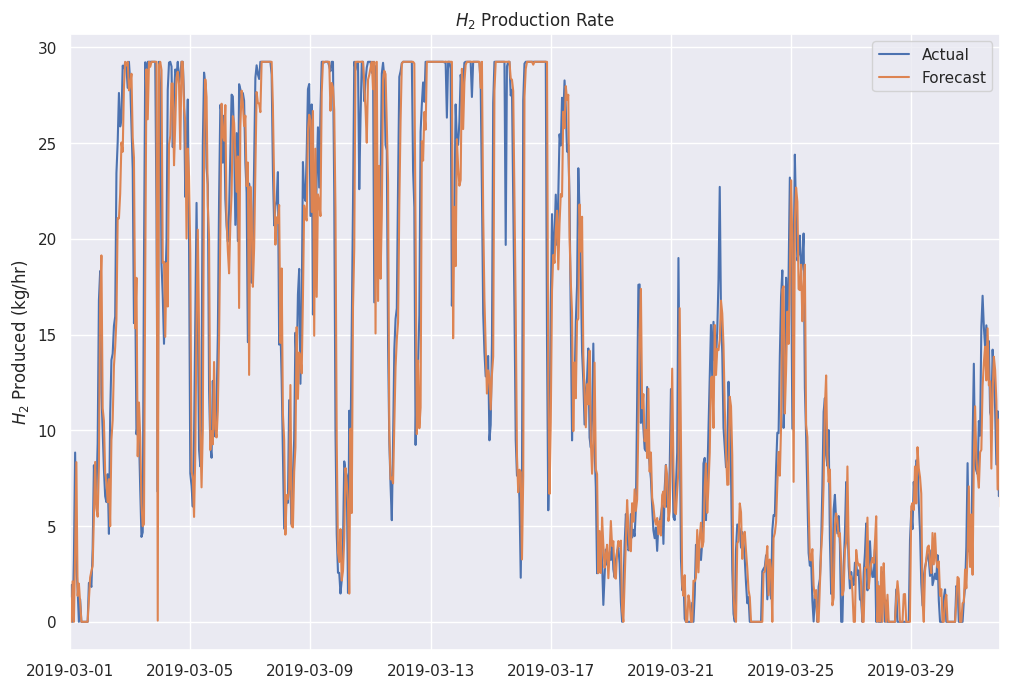

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)

ax.set_title("$H_2$ Production Rate")
ax.set_ylabel("$H_2$ Produced (kg/hr)")
ax.plot(test.index, h2_prod.kg_rate, label="Actual")
ax.plot(test.index[1:], h2_prod_fcast.kg_rate, label="Forecast")

ax.legend()

figs["sim_h2_fcast"] = fig

In [25]:
h2_rmse = mean_squared_error(h2_prod.kg_rate.values[1:], h2_prod_fcast.kg_rate.values, squared=False)
h2_mae = mean_absolute_error(h2_prod.kg_rate.values[1:], h2_prod_fcast.kg_rate.values)

print(f"Mean H2 production rate: {h2_prod.kg_rate.mean()} kg/hr\n")
print(f"H2 Forecast RMSE: {h2_rmse} kg/hr")
print(f"H2 Forecast MAE: {h2_mae} kg/hr\n")

h2_total = h2_prod.kg_rate.sum()
h2_fcast_total = h2_prod_fcast.kg_rate.sum()

print(f"Total H2 production: {h2_total} kg")
print(f"Total forecasted H2 production: {h2_fcast_total} kg")

Mean H2 production rate: 14.068793863468866 kg/hr

H2 Forecast RMSE: 3.570834098003243 kg/hr
H2 Forecast MAE: 2.2972487626690286 kg/hr

Total H2 production: 10467.182634420837 kg
Total forecasted H2 production: 10263.934078331986 kg


In [26]:
if SAVE_FIGS:
    save_figs(figs)